# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader


# Download Dataset

In [2]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:14<00:00, 127MB/s]
100% 1.83G/1.83G [00:14<00:00, 136MB/s]


In [4]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)  

In [ ]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [ ]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4549),
 tensor(0.),
 tensor(1.))

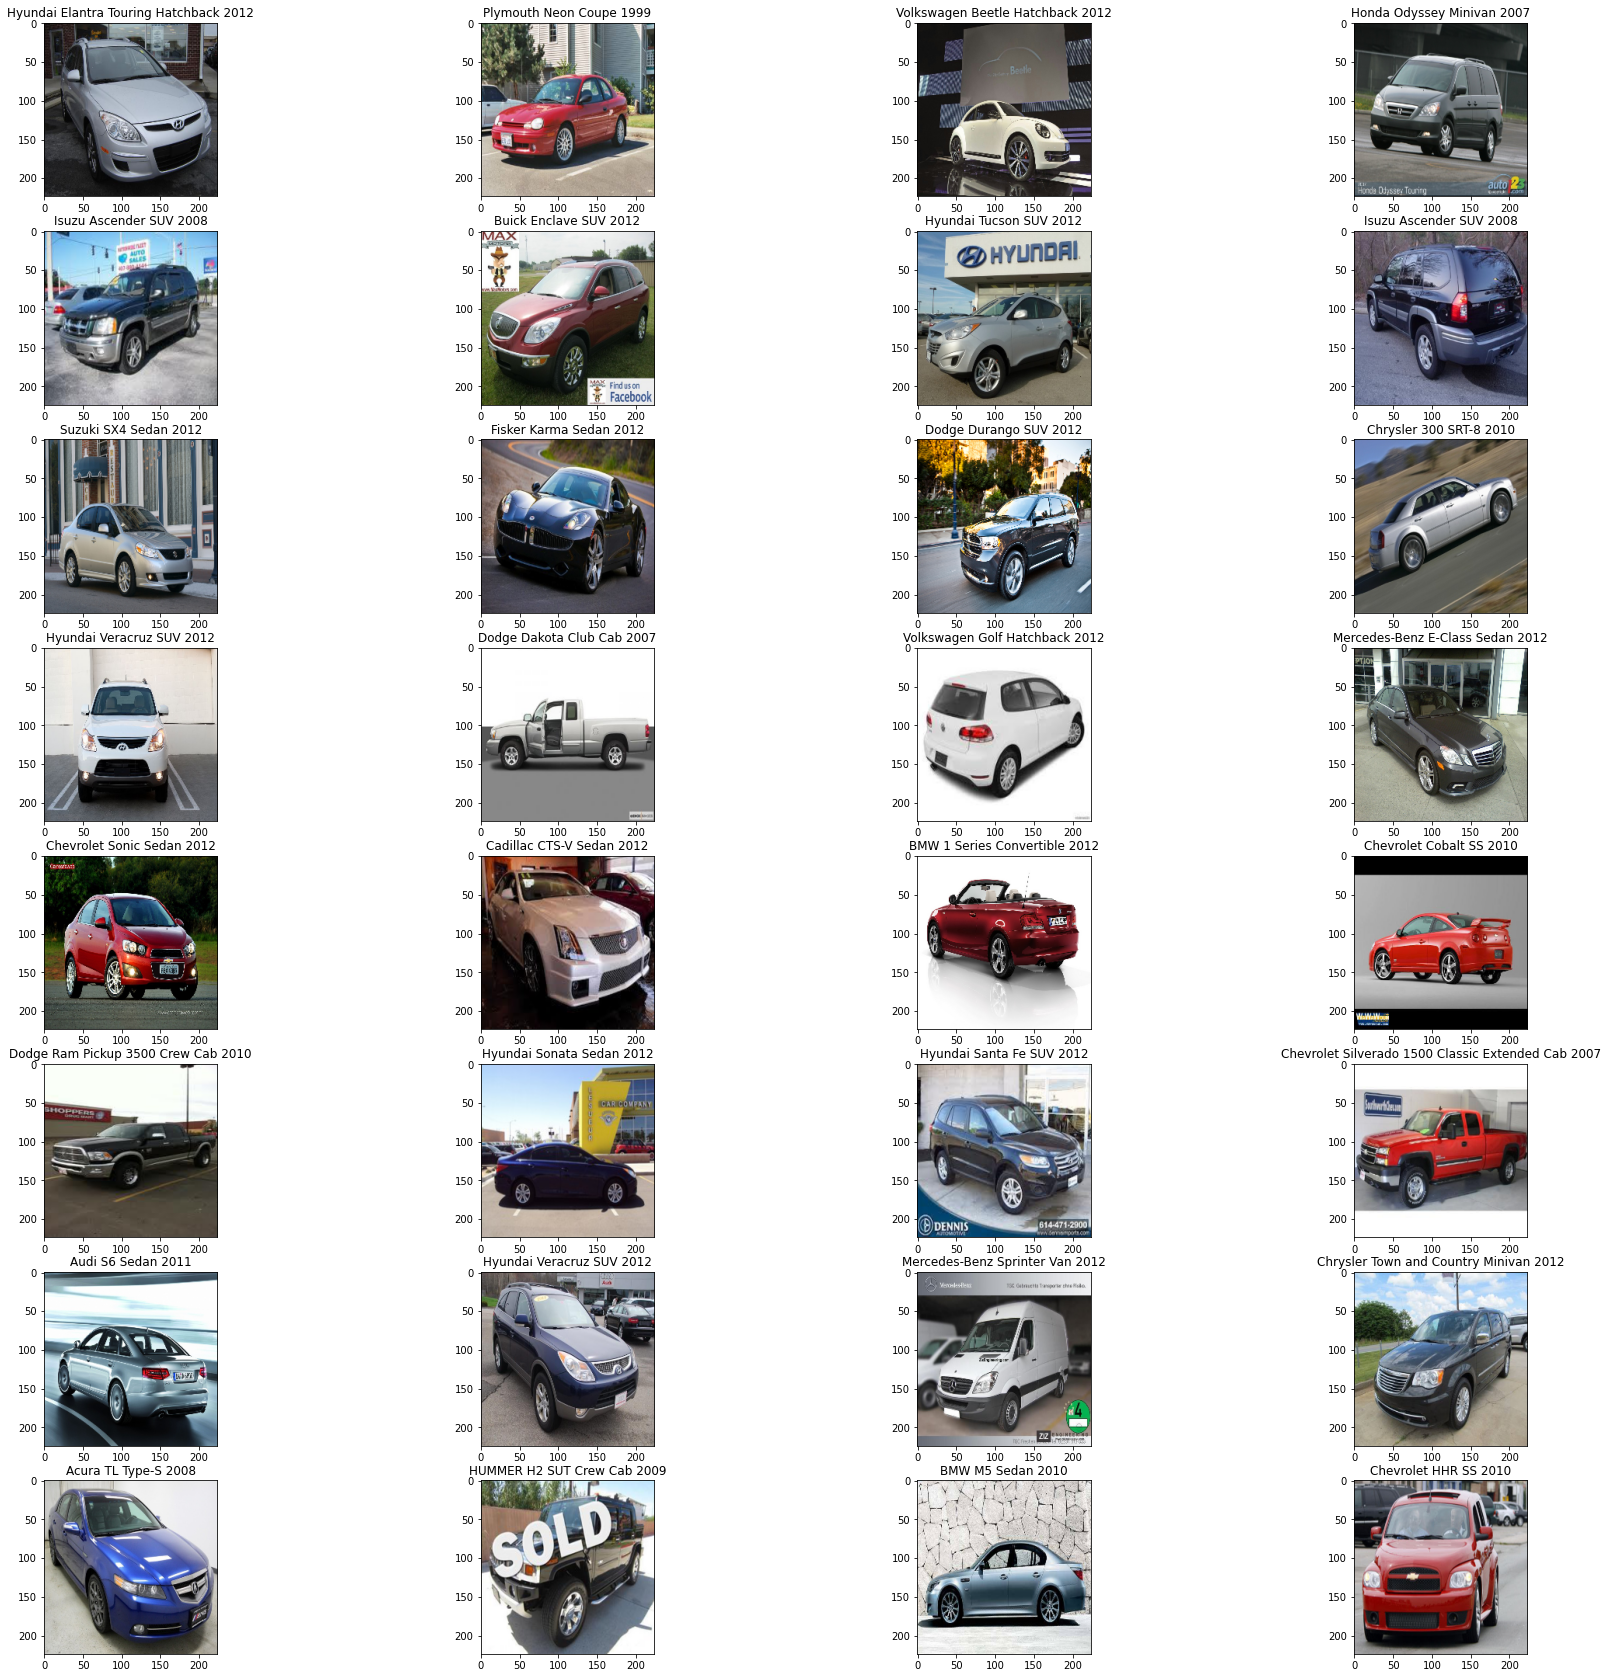

In [6]:
import numpy as np

classes = list(train_data.class_to_idx)


test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [7]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                current_corrects += torch.sum(preds == labels.data)            


            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = 100/32*current_corrects/dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [ ]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

res_mod = models.resnet50(pretrained=True)
model = ResnetModel(res_mod, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

pytorch_total_params=  23909636
pytorch_total_trainable_params=  23909636


In [ ]:
model

ResnetModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train with Random Weights

In [ ]:
res_mod2 = models.resnet50(pretrained=False)
model = ResnetModel(res_mod2, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

pytorch_total_params=  23909636
pytorch_total_trainable_params=  23909636


In [ ]:
model

ResnetModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
PATH = f'/content/drive/MyDrive/HW10/save/first_model.pth'

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

if(os.path.isfile(PATH)):
  load_checkpoint(torch.load(PATH), model)
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


checkpoint = {'state_dict': base_model.state_dict(), 'optimizer': optimizer_ft.state_dict()}
save_checkpoint(checkpoint, PATH)

=> loading checkpoint
Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 152.9561 Acc: 3.4191
Iterating through data...
val Loss: 156.0285 Acc: 3.0630

Epoch 1/9
----------
Iterating through data...
train Loss: 147.7550 Acc: 4.1912
Iterating through data...
val Loss: 152.7638 Acc: 3.7326

Epoch 2/9
----------
Iterating through data...
train Loss: 142.1136 Acc: 5.3922
Iterating through data...
val Loss: 150.6850 Acc: 4.6999

Epoch 3/9
----------
Iterating through data...
train Loss: 137.0372 Acc: 6.5319
Iterating through data...
val Loss: 143.2909 Acc: 5.4688

Epoch 4/9
----------
Iterating through data...
train Loss: 132.1725 Acc: 8.0147
Iterating through data...
val Loss: 139.5121 Acc: 7.1181

Epoch 5/9
----------
Iterating through data...
train Loss: 125.5628 Acc: 10.5025
Iterating through data...
val Loss: 138.2287 Acc: 7.1925

Epoch 6/9
----------
Iterating through data...
train Loss: 108.6612 Acc: 18.4436
Iterating through data...
val Loss: 124.9041 Acc: 13.1076

Epoch 7/9
----------
Iterating through data...
train Loss: 101.8361 Acc: 21.71

# Feature Extractor

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.fc = nn.Sequential(
          nn.Flatten(),
          nn.Linear(2048, 1024),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Dropout(p=0.5),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        f = self.fc(f)
        y = self.classifier(f)
        return y


model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

model_conv = ResnetModel(model_conv, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model_conv.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model_conv.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

pytorch_total_params=  26231556
pytorch_total_trainable_params=  2723524
Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 168.6170 Acc: 0.4657
Iterating through data...
val Loss: 168.1838 Acc: 1.0169

Epoch 1/9
----------
Iterating through data...
train Loss: 168.4239 Acc: 0.6740
Iterating through data...
val Loss: 167.9891 Acc: 1.2649

Epoch 2/9
----------
Iterating through data...
train Loss: 168.1400 Acc: 0.9926
Iterating through data...
val Loss: 167.7478 Acc: 1.3889

Epoch 3/9
----------
Iterating through data...
train Loss: 167.9426 Acc: 0.9069
Iterating through data...
val Loss: 167.4703 Acc: 1.7733

Epoch 4/9
----------
Iterating through data...
train Loss: 167.6606 Acc: 1.0294
Iterating through data...
val Loss: 167.1106 Acc: 2.1701

Epoch 5/9
----------
Iterating through data...
train Loss: 167.2608 Acc: 1.1520
Iterating through data...
val Loss: 166.6097 Acc: 2.5918

Epoch 6/9
----------
Iterating through data...
train Loss: 166.9853 Acc: 1.6176
Iterating through data...
val Loss: 166.5626 Acc: 2.6042

Epoch 7/9
----------
Iterating through data...
train Loss: 166.8475 Acc: 1.3725
I

# SVM

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.svm import SVC
from joblib import dump, load

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def feature_extraction(model, num_epochs=10):    
    start = time.time()
    feature = []
    target = []
    step = False
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # feature extraction
            outputs = model(inputs)
            classifier_input = outputs.to('cpu').detach().numpy()
            classifier_target = labels.to('cpu').detach().numpy()
            if step:
                preds = svm_model.predict(classifier_input)
                running_corrects += np.sum(preds == classifier_target)
            svm_model.fit(classifier_input, classifier_target)
            step = True

        
        epoch_acc = running_corrects / dataset_sizes['train']                                   
        print('{} Acc: {:.4f}'.format('train', 0, epoch_acc))

        print()

    # Calculating time it took for model to train    
    time_elapsed = time.time() - start
    print('Extracting complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return feature, target

resnet_model =  models.resnet50(pretrained=True)
resnet_model.to(device)
svm_model = SVC(kernel = 'poly', C = 1)

# freeze the parameters
for param in resnet_model.parameters():
  param.require_grad = False

features, targets = feature_extraction(resnet_model, 15)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1/15
----------
train Acc: 0.0000

Epoch 2/15
----------
train Acc: 0.0000

Epoch 3/15
----------
train Acc: 0.0000

Epoch 4/15
----------
train Acc: 0.0000

Epoch 5/15
----------
train Acc: 0.0000

Epoch 6/15
----------
train Acc: 0.0000

Epoch 7/15
----------
train Acc: 0.0000

Epoch 8/15
----------
train Acc: 0.0000

Epoch 9/15
----------
train Acc: 0.0000

Epoch 10/15
----------
train Acc: 0.0000

Epoch 11/15
----------
train Acc: 0.0000

Epoch 12/15
----------
train Acc: 0.0000

Epoch 13/15
----------
train Acc: 0.0000

Epoch 14/15
----------
train Acc: 0.0000

Epoch 15/15
----------
train Acc: 0.0000

Extracting complete in 30m 38s


# Fine Tune

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.fc = nn.Sequential(
          nn.AdaptiveAvgPool1d(2048),
          nn.Flatten(),
          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True),
          nn.Linear(2048, 1024),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Dropout(p=0.5),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        f = self.fc(f)
        y = self.classifier(f)
        return y


model_conv = torchvision.models.resnet50(pretrained=True)
ct = 0
for child in model_conv.children():
  ct += 1
  if ct < 7:
    for param in child.parameters():
        param.requires_grad = False

model_conv = ResnetModel(model_conv, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model_conv.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model_conv.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

PATH = f'/content/drive/MyDrive/HW10/save/fourth_model.pth'

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

if(os.path.isfile(PATH)):
  load_checkpoint(torch.load(PATH), model)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

checkpoint = {'state_dict': model_conv.state_dict(), 'optimizer': optimizer_ft.state_dict()}
save_checkpoint(checkpoint, PATH)

pytorch_total_params=  26235652
pytorch_total_trainable_params=  24790724
Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 168.6139 Acc: 0.6005
Iterating through data...
val Loss: 167.3685 Acc: 1.4881

Epoch 1/9
----------
Iterating through data...
train Loss: 167.2351 Acc: 1.3113
Iterating through data...
val Loss: 166.0558 Acc: 3.6582

Epoch 2/9
----------
Iterating through data...
train Loss: 165.4959 Acc: 2.0833
Iterating through data...
val Loss: 164.3366 Acc: 5.0967

Epoch 3/9
----------
Iterating through data...
train Loss: 163.4222 Acc: 3.3946
Iterating through data...
val Loss: 162.0901 Acc: 6.4484

Epoch 4/9
----------
Iterating through data...
train Loss: 160.9887 Acc: 4.2770
Iterating through data...
val Loss: 159.1420 Acc: 7.7009

Epoch 5/9
----------
Iterating through data...
train Loss: 157.9619 Acc: 5.1961
Iterating through data...
val Loss: 155.8115 Acc: 8.7054

Epoch 6/9
----------
Iterating through data...
train Loss: 155.8177 Acc: 5.8701
Iterating through data...
val Loss: 155.3822 Acc: 8.4449

Epoch 7/9
----------
Iterating through data...
train Loss: 155.4693 Acc: 6.3971
I